In [1736]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

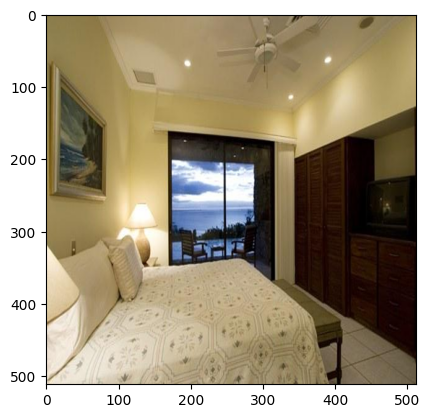

In [1737]:
i = 40

image = np.array(Image.open(f'/Users/richardkuodis/development/pytorch-layoutnet/res/lsun_tr_gt/img/{i}.png'))
plt.imshow(image);

In [1738]:
lines = [
    ((116, 100), (72, 0)),
    ((116, 396), (64, 511)),
    ((344, 370), (511, 479)),
    ((342, 133), (496, 0)),
    ((116, 100), (116, 396)),
    ((116, 396), (344, 370)),
    ((344, 370), (342, 133)),
    ((342, 133), (116, 100))
]

# lines = [
#     ((116, 100), (72, 0)),
#     ((116, 396), (64, 511)),
#     ((344, 370), (511, 479)),
#     ((342, 133), (496, 0)),
    
#     ((60, 100), (116, 396)),

#     ((116, 396), (344, 370)),

#     ((344, 370), (240, 133)),

#     ((342, 133), (116, 100))
# ]


colors = [
    (255, 0, 0), # Red
    (0, 255, 0), # Green
    (0, 0, 255), # Blue
    (255, 255, 0), # Yellow
    (255, 102, 178), # Pink
    (102, 255, 255), # Cyan
    (255, 255, 255), #  White
    (255, 153, 51), # Orange
]

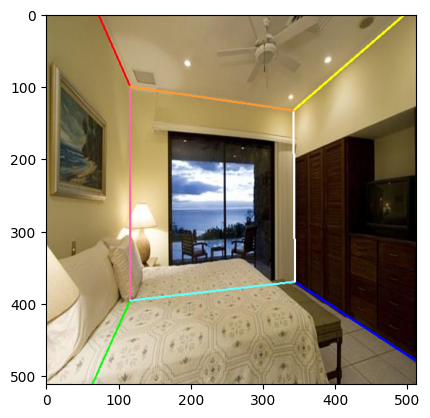

In [1739]:
image_overlay = image.copy()

for line_idx, (p1, p2) in enumerate(lines):
    image_overlay = cv2.line(
        image_overlay,
        p1, 
        p2, 
        colors[line_idx],
        2
    )

plt.imshow(image_overlay);

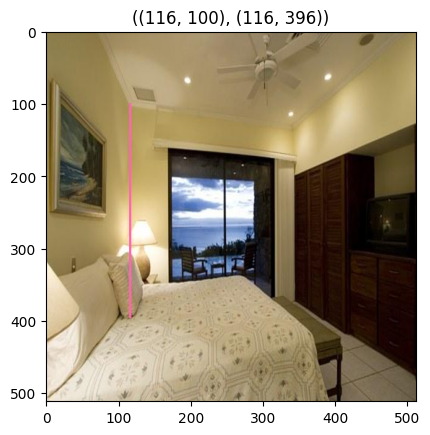

In [1740]:
line_idx = 4

line = lines[line_idx]

# FIXME: for debug
line = (
    (line[0][0], line[0][1]),
    (line[1][0], line[1][1])
)

image_tmp = image.copy()

image_tmp = cv2.line(
    image_tmp,
    line[0], 
    line[1], 
    colors[line_idx],
    2
)

plt.imshow(image_tmp)
plt.title(f'{line}');

In [1741]:
def line_image_coords_to_geo(lines, size=(512, 512)):
    """
    Converts lines coordinates from image space to geometry
    """
    width, height = size

    lines_geo = []
    for (p1, p2) in lines:
        p1 = (p1[0], height -1 - p1[1])
        p2 = (p2[0], height -1 - p2[1])
        lines_geo.append((p1, p2))
    
    return lines_geo

def line_geo_coords_to_image(lines, size=(512, 512)):
    width, height = size

    lines_geo = []
    for (p1, p2) in lines:
        p1 = (p1[0], height -1 - p1[1])
        p2 = (p2[0], height -1 - p2[1])
        lines_geo.append((p1, p2))
    
    return lines_geo

In [1742]:
lines_geo = line_image_coords_to_geo(lines)
lines_geo

[((116, 411), (72, 511)),
 ((116, 115), (64, 0)),
 ((344, 141), (511, 32)),
 ((342, 378), (496, 511)),
 ((116, 411), (116, 115)),
 ((116, 115), (344, 141)),
 ((344, 141), (342, 378)),
 ((342, 378), (116, 411))]

In [1743]:
line_geo = lines_geo[line_idx]

line_geo, line

(((116, 411), (116, 115)), ((116, 100), (116, 396)))

Compute left ending line params

In [1744]:
def compute_line_params(line):
    if line[0][0] == line[1][0]:
        padding = 0.00001
    else:
        padding = 0.
    
    a, b = np.polyfit(
        [line[0][0], line[1][0] + padding],
        [line[0][1], line[1][1]],
        1
    )
    return a, b

In [1745]:
a, b = compute_line_params(line_geo)

print(f'Left line equation: {a:0.4f}x + {b:0.4f}')

Left line equation: -29599999.9716x + 3433600407.7082


In [1746]:
def compute_y_at_x(a, b, x):
    return a * x + b

def compute_x_at_y(a, b, y):
    # y = a*x + b => ax = y - b => x = (y - b) / a
    return (y - b) / a

In [1747]:
a

-29599999.971622553

In [1748]:
if a > 0:
    # If left line slope is greater than zero, that is, line goes from left to right: /,
    # then left ending line shall touch top-left point
    print('Slope is greater than zero, left line will touch top left bound of the image')
    corner_point = (0, 511)
else:
    # Line goes from right to left: \
    # It shall touch the bottom left point
    print('Slope is less than zero, left line will touch bottom left bound of the image')
    corner_point = (0, 0)

print(f'Corner point: {corner_point}')

Slope is less than zero, left line will touch bottom left bound of the image
Corner point: (0, 0)


In [1749]:
x, y = corner_point

# y = ax + b => b = y - ax
b_left = y - a * x

b_left

0.0

In [1750]:
def compute_lines_intersection(a1, b1, a2, b2):
    """
    Given two lines 'y = a1 * x + b2 and 'y = a2 * x + b2', finds point of intersection (x, y).

    a2 * x + b2 = a1 * x + b1
    a2 * x - a1 * x = b1 - b2
    (a2 - a1) * x = b1 - b2
    x = (b1 - b2) / (a2 - a1)
    """

    x = (b1 - b2) / (a2 - a1)
    y = a1 * x + b1 # or y = a2 * x + b2, doesn't matter
    return (x, y)

In [1751]:
# Now we need to find where left line intersect with with top and bottom lines
line_top = lines_geo[0]

a_top, b_top = compute_line_params(line_top)

top_intersection_point = compute_lines_intersection(a, b_left, a_top, b_top)

top_intersection_point

(-2.279177081360186e-05, 674.6364154358428)

In [1752]:
line_bottom = lines_geo[1]

a_bottom, b_bottom = compute_line_params(line_bottom)

bottom_intersection_point = compute_lines_intersection(a, b_left, a_bottom, b_bottom)

bottom_intersection_point

(4.781704429028066e-06, -141.53845096353817)

In [1753]:
line_left = (top_intersection_point, bottom_intersection_point)

line_top = (line_top[0], top_intersection_point)
line_bottom = (line_bottom[0], bottom_intersection_point)

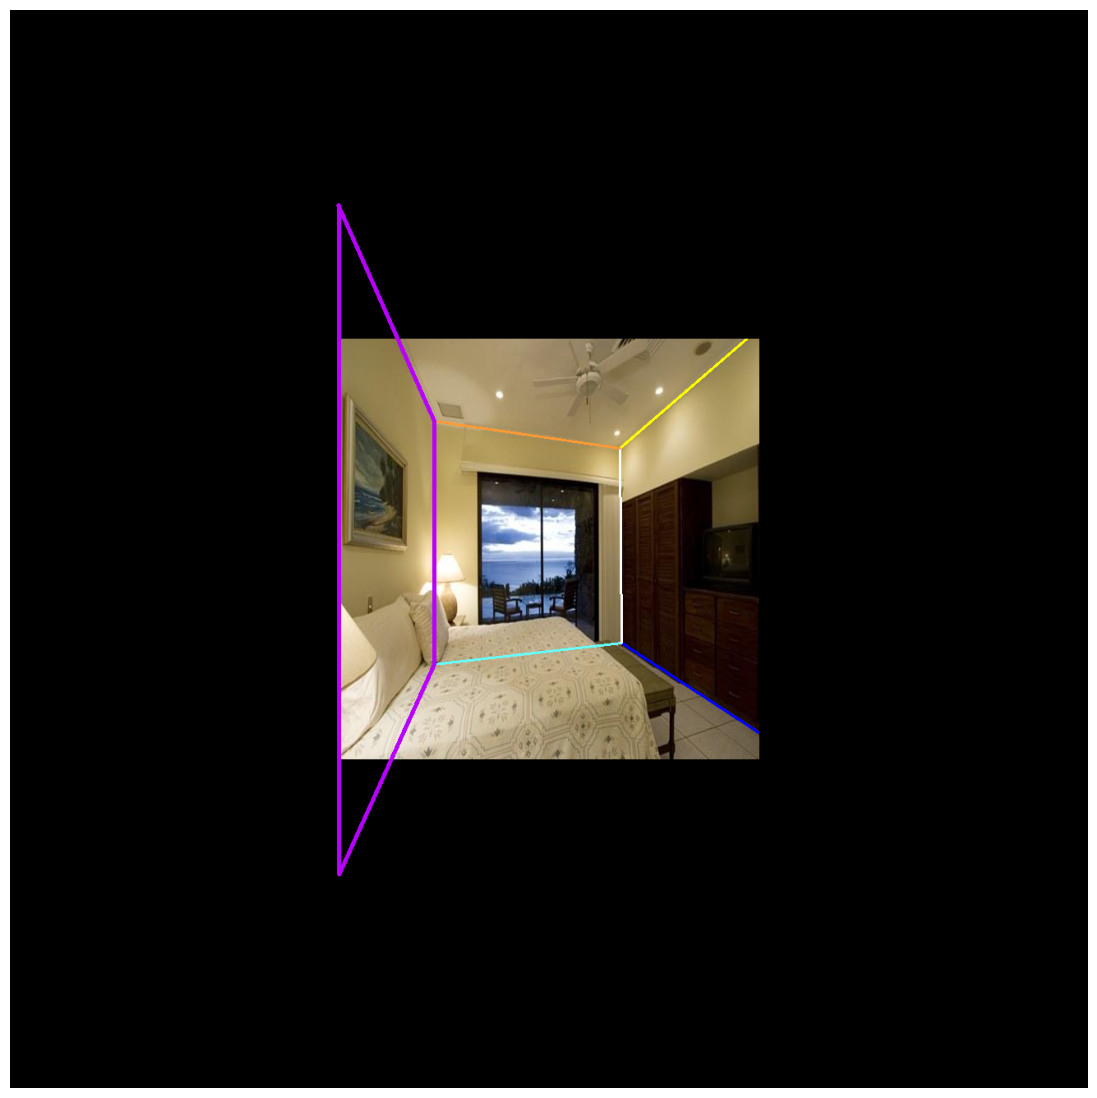

In [1754]:
left_lines_geo = [
    line_top,
    line_geo,
    line_bottom,
    line_left
]

left_lines_image = line_geo_coords_to_image(left_lines_geo)

padding = 400

padded_image = np.pad(image_overlay, pad_width=[(padding, padding), (padding, padding), (0, 0)], mode='constant')

for p1, p2 in left_lines_image:
    image_tmp2 = cv2.line(
        padded_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        (183, 0, 255),
        3
    )

plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(padded_image);

In [1755]:
# Now compute the right polygon
line_geo = lines_geo[6]

a, b = compute_line_params(line_geo)

print(f'Right line equation: {a:0.4f}x + {b:0.4f}')

Right line equation: -118.5000x + 40905.0000


In [1756]:
if a > 0:
    corner_point = (511, 0)
else:
    corner_point = (511, 511)

print(f'Corner point: {corner_point}')

Corner point: (511, 511)


In [1757]:
x, y = corner_point

b_right = y - a * x

b_right

61064.500000001564

In [1758]:
line_top = lines_geo[3]

a_top, b_top = compute_line_params(line_top)

top_intersection_point = compute_lines_intersection(a, b_right, a_top, b_top)

top_intersection_point

(510.8914699162225, 523.8608149276406)

In [1759]:
line_bottom = lines_geo[2]

a_bottom, b_bottom = compute_line_params(line_bottom)

bottom_intersection_point = compute_lines_intersection(a, b_right, a_bottom, b_bottom)

bottom_intersection_point

(515.0645816925382, 29.347069434210425)

In [1760]:
line_right = (top_intersection_point, bottom_intersection_point)

line_top = (line_top[0], top_intersection_point)
line_bottom = (line_bottom[0], bottom_intersection_point)

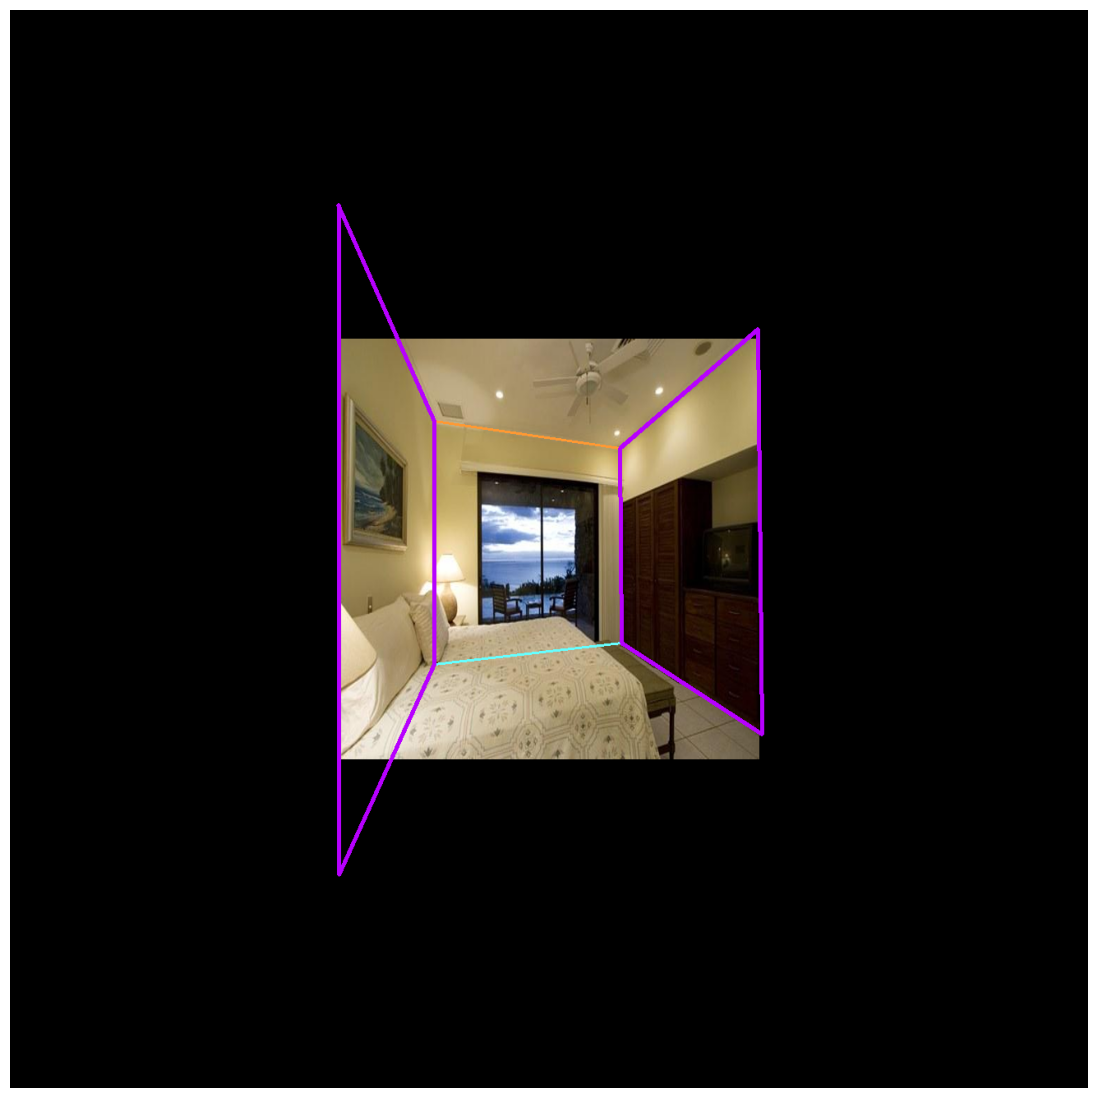

In [1761]:
right_lines_geo = [
    line_top,
    line_geo,
    line_bottom,
    line_right
]

right_lines_image = line_geo_coords_to_image(right_lines_geo)

padding = 400

# padded_image = np.pad(image_overlay, pad_width=[(padding, padding), (padding, padding), (0, 0)], mode='constant')

for p1, p2 in right_lines_image:
    image_tmp2 = cv2.line(
        padded_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        (183, 0, 255),
        3
    )

plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(padded_image);

In [1762]:
# Assemble polygons
line_center_left = lines[4]
line_center_top = lines[7]
line_center_bottom = lines[5]
line_center_right = lines[6]
line_top_left = lines[0]
line_bottom_left = lines[1]
line_top_right = lines[3]
line_bottom_right = lines[2]

line_left_left = line_left
line_right_right = line_right

# Left polygon
# Point order: top_left, top_right, bottom_right, bottom_left
polygon_left = [
    line_left_left[1],
    line_center_left[0],
    line_center_left[1],
    line_left_left[0]
]
print(f'Left polygon: {polygon_left}')

polygon_center = [
    line_center_left[0],
    line_center_right[1],
    line_center_right[0],
    line_center_left[1]
]

polygon_right = [
    line_center_right[1],
    line_right_right[1],
    line_right_right[0],
    line_center_right[0]
]

Left polygon: [(4.781704429028066e-06, -141.53845096353817), (116, 100), (116, 396), (-2.279177081360186e-05, 674.6364154358428)]


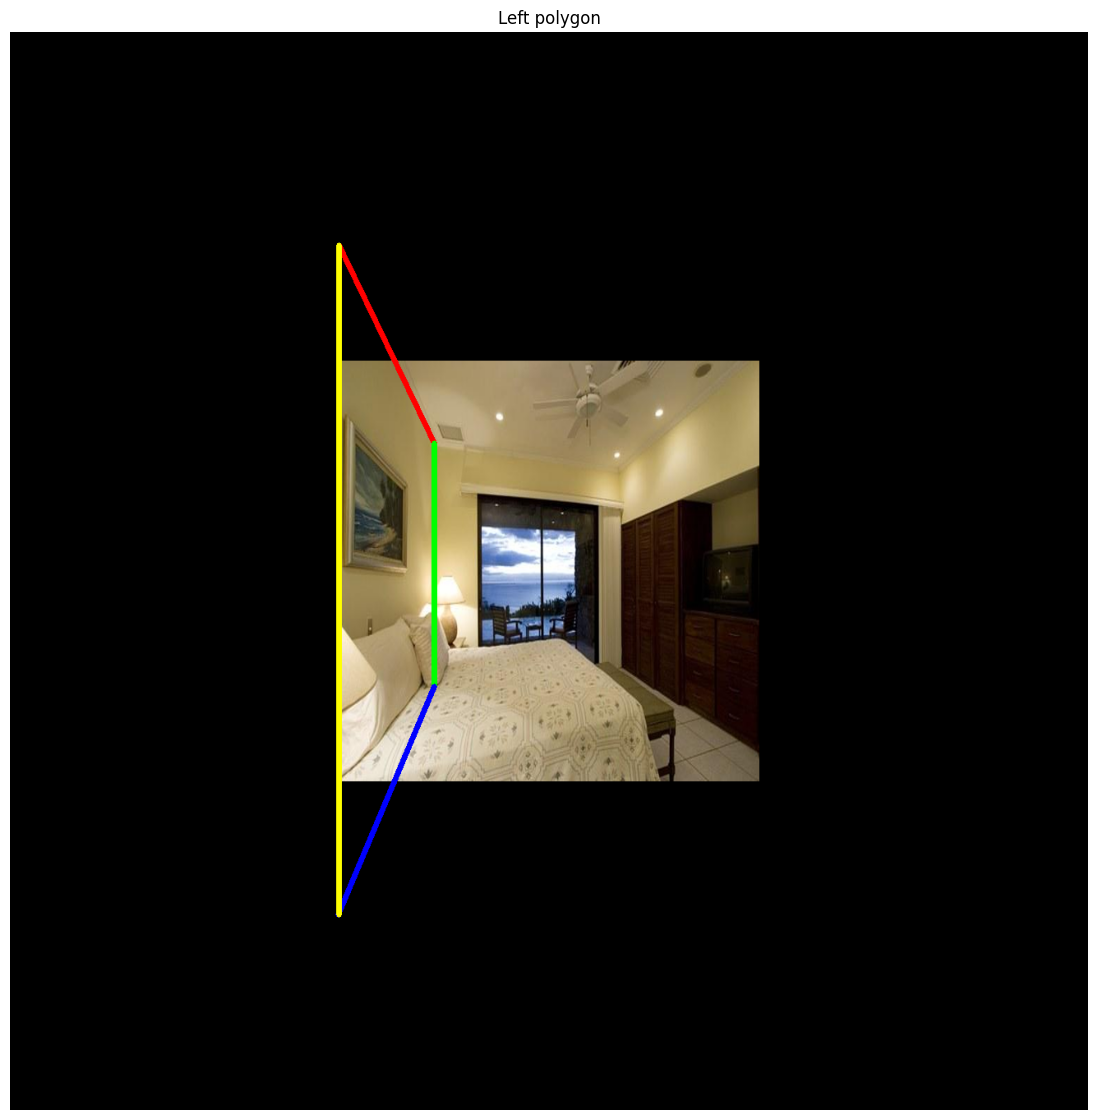

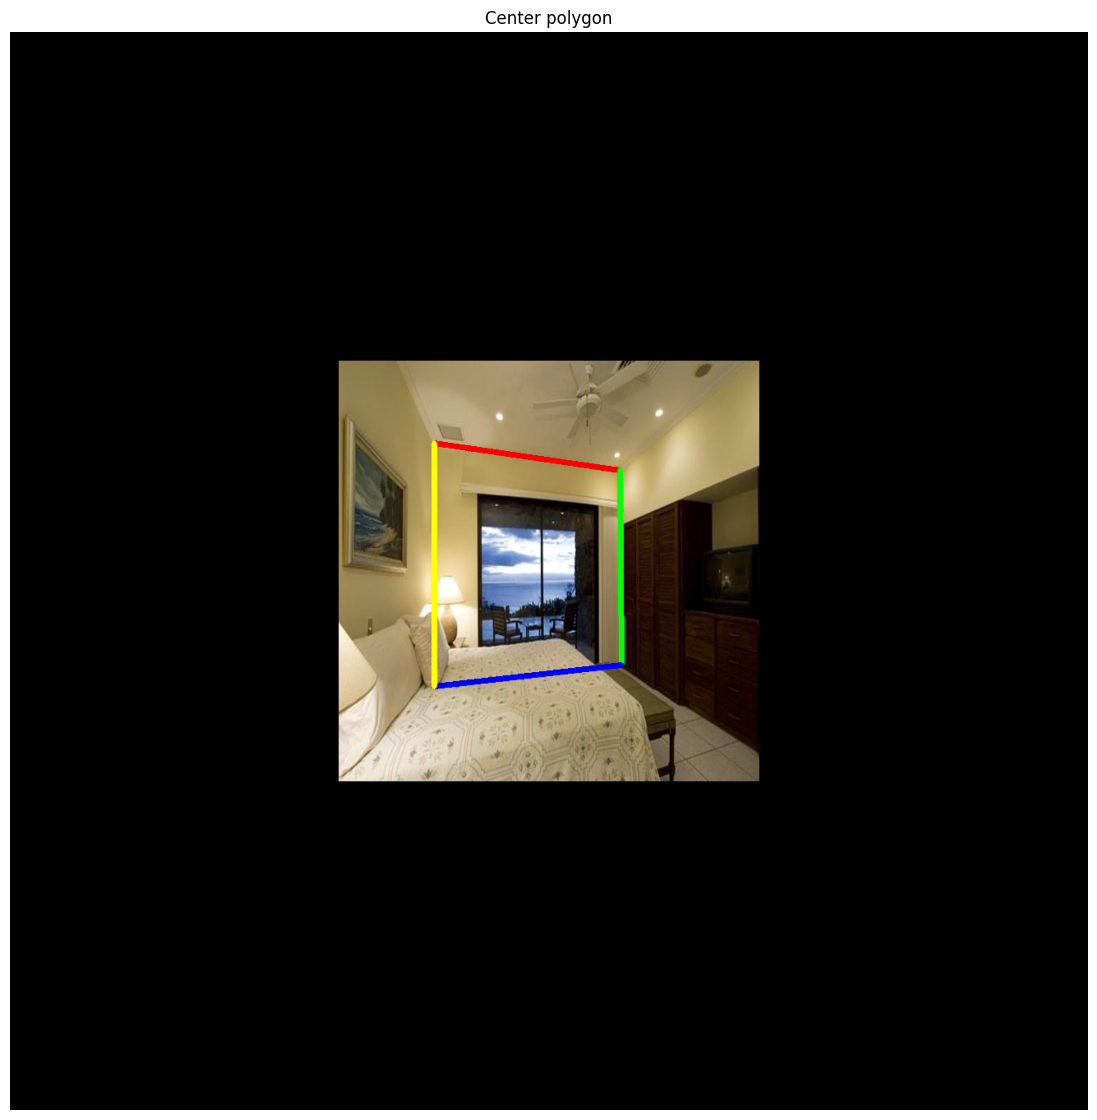

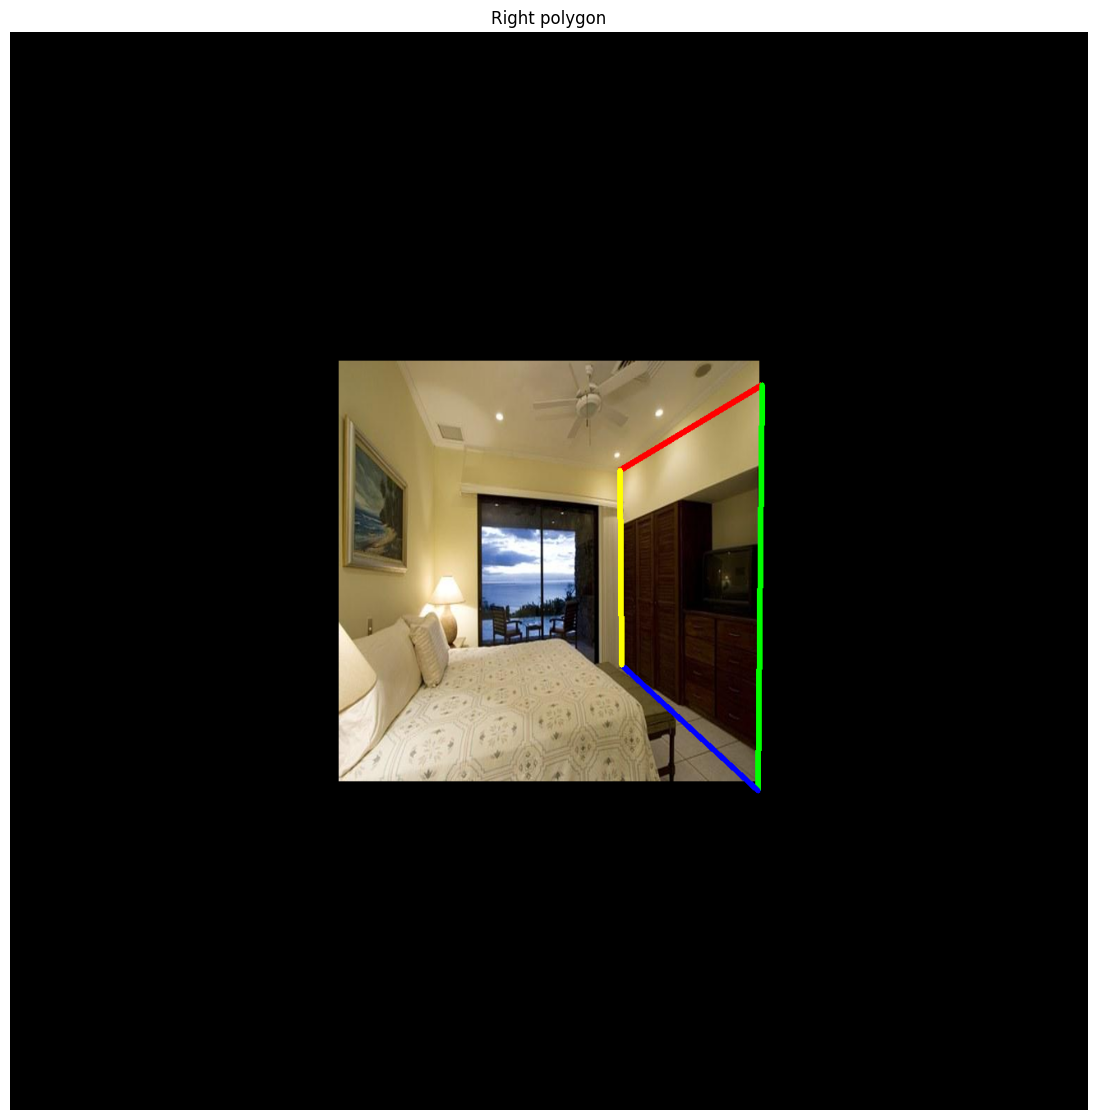

In [1763]:
padding = 400

padded_image = np.pad(image, pad_width=[(padding, padding), (padding, padding), (0, 0)], mode='constant')

polygon_image = padded_image.copy()
for i in range(0, 4):
    p1 = polygon_left[i]
    p2 = polygon_left[(i + 1) % 4]
    cv2.line(
        polygon_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        colors[i],
        5
    )

plt.figure(figsize=(14, 14))
plt.title('Left polygon')
plt.axis('off')
plt.imshow(polygon_image);

# Center
polygon_image = padded_image.copy()
for i in range(0, 4):
    p1 = polygon_center[i]
    p2 = polygon_center[(i + 1) % 4]
    cv2.line(
        polygon_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        colors[i],
        5
    )

plt.figure(figsize=(14, 14))
plt.title('Center polygon')
plt.axis('off')
plt.imshow(polygon_image);

# Right
polygon_image = padded_image.copy()
for i in range(0, 4):
    p1 = polygon_right[i]
    p2 = polygon_right[(i + 1) % 4]
    cv2.line(
        polygon_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        colors[i],
        5
    )

plt.figure(figsize=(14, 14))
plt.title('Right polygon')
plt.axis('off')
plt.imshow(polygon_image);